In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
import astropy.units as u
import astropy.constants as c

import abundances
import minerals
import VY1995
from molecules import Molecule

# Play with different gas mixtures

Use Verner & Yaklovev cross-sections to obtain absorption from X-ray to UV

In [3]:
WAVEL = np.linspace(0.1, 600.0, 5000) * u.nm
ENER  = WAVEL.to(u.eV, equivalencies=u.spectral())

In [4]:
N2 = Molecule({'N':2}, name='N_2')
O2 = Molecule({'O':2}, name='O_2')
Ar = Molecule({'Ar':1}, name='Ar')
CO2 = Molecule({'C':1, 'O':2}, name='CO_2')
Ne = Molecule({'Ne':1}, name='Ne')
O3 = Molecule({'O':3}, name='O_3')
He = Molecule({'He':1}, name='He')
CH4 = Molecule({'C':1, 'H':4}, name='CH_4')

## Earth atmosphere

From Table 1.1 of Chance & Martin (book: *Spectroscopy & Radiative Transfer of Planetary Atmospheres*)

In [5]:
# list of tuples that describe molecular composition, by number
earth_atmosphere = [(N2,0.78), (O2,0.21), (Ar, 9.3e-3), 
                    (CO2, 400.e-6), (Ne, 18.e-6), (O3, 0.1e-6), 
                    (He, 5.2e-6), (CH4, 1.8e-6)]

# Some essential values
earth_mean_mol   = 0.0289644 * u.kg / u.mol # mean molecular weight for dry air
earth_mean_temp  = 288. * u.K
earth_mean_num   = u.pascal / (c.R * earth_mean_temp) * c.N_A # mean number dens of molecules, mol/vol

In [6]:
earth_mean_num.to('cm^-3')

<Quantity 2.51492121e+14 1 / cm3>

In [7]:
def calculate_elemental_number_density(mix, mean_num_dens=earth_mean_num, verbose=False):
    """
    Inputs
    ------
    mix : list of tuples (Molecule, float)
        The float describes fraction (by number) that the molecule occupies in the atmosphere
    
    mean_num_dens : float
        Mean number density of molecules in the atmosphere (default: Earth)
    """
    result = {}
    for molecule, frac in mix:
        for ele in molecule.elements:
            if verbose: print('{} : {}: n={}'.format(molecule.name, ele, molecule.number(ele)))
            if ele in result.keys():
                result[ele] += mean_num_dens * frac * molecule.number(ele)
            else:
                result[ele] = mean_num_dens * frac * molecule.number(ele)
    return result

In [8]:
earth_elem_num_dens = calculate_elemental_number_density(earth_atmosphere, verbose=True)

N_2 : N: n=2
O_2 : O: n=2
Ar : Ar: n=1
CO_2 : C: n=1
CO_2 : O: n=2
Ne : Ne: n=1
O_3 : O: n=3
He : He: n=1
CH_4 : C: n=1
CH_4 : H: n=4


In [9]:
for ele in earth_elem_num_dens.keys():
    print('{} : {:.1e}'.format(ele, earth_elem_num_dens[ele].to('cm^-3')))

N : 3.9e+14 1 / cm3
O : 1.1e+14 1 / cm3
Ar : 2.3e+12 1 / cm3
C : 1.0e+11 1 / cm3
Ne : 4.5e+09 1 / cm3
He : 1.3e+09 1 / cm3
H : 1.8e+09 1 / cm3


Now computer VY 1995 cross-sections for these abundances

In [10]:
xsects = {ele:VY1995.compute_xsect(ENER, abundances.Z[ele], 0) * earth_elem_num_dens[ele]
          for ele in earth_elem_num_dens.keys()}

total_xsect = np.zeros(len(ENER)) / u.cm
for ele in earth_elem_num_dens:
    total_xsect += xsects[ele]

In [11]:
def plot_bands(ax):
    # these are in nm units
    # Some energy bands for Astro-Sat. Update with a different telescope at some point
    ax.axvspan(130., 180., facecolor='magenta', alpha=0.5)
    ax.axvspan(180., 300., facecolor='blue', alpha=0.5)
    ax.axvspan(320., 530., facecolor='cyan', alpha=0.5)
    ax.axvspan(12.4/8.0/10., 12.4/0.3/10., facecolor='orange', alpha=0.3) # X-ray band

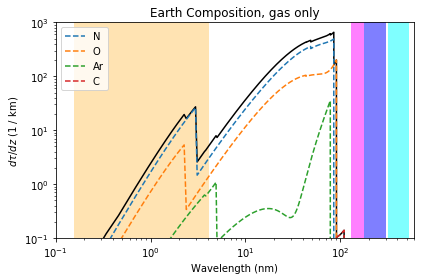

In [19]:
ax = plt.subplot(111)

YLIM = [0.1, 1.e3]
plt.plot(WAVEL, total_xsect.to('km^-1'), color='k')
for ele in earth_elem_num_dens.keys():
    if np.max(xsects[ele].to('km^-1').value) > YLIM[0]:
        plt.plot(WAVEL, xsects[ele].to('km^-1'), ls='--', label=ele)

plt.loglog()
plt.xlim(0.1, 600)
plt.ylim(YLIM)
plt.xlabel('Wavelength ({})'.format(WAVEL.unit))
plt.ylabel(r'$d\tau/dz$ ({})'.format(total_xsect.to('km^-1').unit))
plt.legend(loc='upper left')
plot_bands(ax)

plt.title('Earth Composition, gas only')
plt.tight_layout()
plt.savefig('earth_comp.pdf', format='pdf')

Text(0.5,1,'Earth Composition, atomic phase')

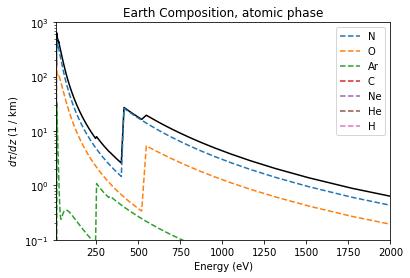

In [13]:
plt.plot(ENER, total_xsect.to('km^-1'), color='k')
for ele in earth_elem_num_dens.keys():
    plt.plot(ENER, xsects[ele].to('km^-1'), ls='--', label=ele)
plt.semilogy()
plt.xlim(10.0, 2.e3)
plt.ylim(0.1, 1.e3)
plt.xlabel('Energy ({})'.format(ENER.unit))
plt.ylabel(r'$d\tau/dz$ ({})'.format(total_xsect.to('km^-1').unit))
plt.legend(loc='upper right')

plt.title('Earth Composition, atomic phase')

## Why do they all cut off around 100 nm?

In [14]:
from astropy.table import Table

In [15]:
vy1995 = Table.read(VY1995.VY_TABLE_FILE, format='ascii')

In [16]:
vy1995.colnames

['Z', 'N', 'n', 'l', 'E_th_', 'E_0_', 'sigma_0_', 'y_a_', 'P', 'y_w_']

In [17]:
vy1995[['Z','N','n','l','E_th_']][vy1995['Z'] == 8]

Z,N,n,l,E_th_
int64,int64,int64,int64,float64
8,8,2,1,13.6
8,8,2,0,28.5
8,8,1,0,538.0
8,7,2,1,35.1
8,7,2,0,46.0
8,7,1,0,558.0
8,6,2,1,54.9
8,6,2,0,65.5
8,6,1,0,584.0
